In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [3]:
#Select a device
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [4]:
#load the images

imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
     transforms.Resize(imsize), # scale imported image
     transforms.ToTensor() # transform it into a torch tensor
])

def image_loader(image_name):
  image = Image.open(image_name)
  # fake batch dimension required to fit network's input dimensions
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float)

style_img = image_loader("/content/drive/MyDrive/Colab Notebooks/images/picasso.jpg")
content_img =image_loader("/content/drive/MyDrive/Colab Notebooks/images/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

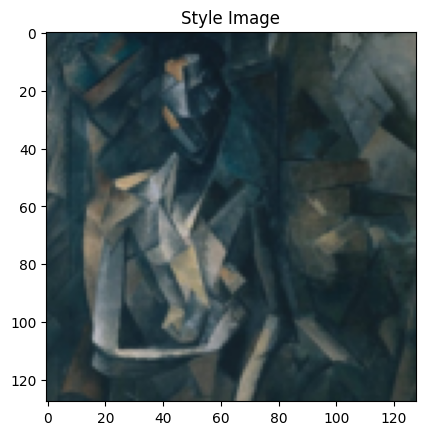

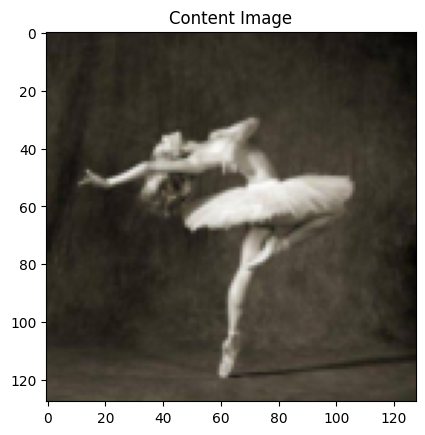

In [5]:
unloader = transforms.ToPILImage() # reconvert into PIL image
#Enable interactive mode, pictures will be automatically shown
plt.ion()

def imshow(tensor, title=None):
  image = tensor.cpu().clone() # we clone the tensor to not do changes on it
  image = image.squeeze(0)     # remove the fake batch dimension
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)             # pause a bit so that plots are updated

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')



In [6]:
# content loss
# designed to be used as a layer in a neural network

class ContentLoss(nn.Module):
  def __init__(self, target,):
    super(ContentLoss, self).__init__()
    # The .detach() method creates a new tensor
    # that shares the data with the original target tensor
    # but is detached from the computational graph.
    # Detaching it ensures that when we calculate the loss
    # the gradients are not propagated back to the original target tensor, preventing unintended changes to it
    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    # to calculate and store the content loss (self.loss), not to modify the input.
    return input

In [18]:
# style loss
def gram_matrix(input):
  a,b,c,d = input.size()
  # reshapes the input tensor into a matrix
  features =  input.view(a*b,c*d)
  # calculates the Gram matrix (G) by performing a matrix multiplication of the features matrix with its transpose
  # The Gram matrix essentially captures the correlations between different feature channels in the input
  G = torch.mm(features,features.t())
  # normalizes the Gram matrix by dividing it by the total number of elements in the original input tensor
  return G.div(a*b*c*d)

In [7]:
class Styleloss(nn.Module):
  def __init__(self, target_feature):
    super(Styleloss, self).__init__()
    self.target = gram_matrix(target_feature).detach()

  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

In [8]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 65.7MB/s]


In [9]:
# defines a PyTorch tensor
# containing the mean values for each color channel (Red, Green, Blue)
# used for normalization
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
# the standard deviation values for each color channel used for normalization
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    # converts the provided mean into a PyTorch tensor
    # and reshapes it to match the expected format for image normalization
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
    # normalize ``img``
    return (img - self.mean) / self.std

In [20]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(
    cnn,normalization_mean, normalization_std,
    style_img, content_img,
    content_layers = content_layers_default,
    style_layers = style_layers_default):

    # Initialization
    normalization = Normalization(normalization_mean,normalization_std)
    content_losses =[]
    style_losses =[]
    # Creates a nn.Sequential model, starting with the normalization layer
    model = nn.Sequential(normalization)

    i=0
    # Building the Model
    # Iterates through layers of a pre-trained VGG19
    for layer in cnn.children():
      if isinstance(layer, nn.Conv2d):
        i +=1
        # Assigns names to layers, like conv_1
        name = 'conv_{}'.format(i)
      elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        layer = nn.ReLU(inplace=False)
      elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
      elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
      else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

      # Adds each layer to the nn.Sequential model
      model.add_module(name, layer)

      # Adding Loss Functions
      if name in content_layers:
        # The .detach() method is used to create a new tensor that shares the same data as the original tensor
        # but is detached from the computational graph
        target = model(content_img).detach()
        # calculates the content loss and adds it to the model and content_losses
        content_loss = ContentLoss(target)
        model.add_module("content_loss_{}".format(i), content_loss)
        content_losses.append(content_loss)
      if name in style_layers:
        target_feature = model(style_img).detach()
        #Calculates styleloss which uses the Gram matrix
        style_loss = Styleloss(target_feature)
        model.add_module("style_loss_{}".format(i), style_loss)
        style_losses.append(style_loss)

    # Trimming the Model
    # Removes layers after the last content or style loss layer
    for i in range(len(model) -1,-1,-1):
      if isinstance(model[i],ContentLoss) or isinstance(model[i],Styleloss):
        break
    #Take all the layers in the model from the beginning up to and including the layer at index i, and discard the rest
    model = model[:(i+1)]

    return model, style_losses, content_losses


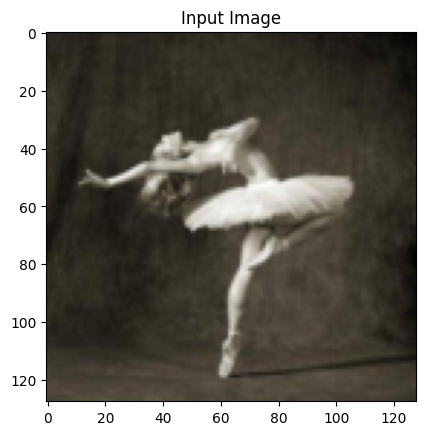

In [11]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

In [12]:
def get_input_optimizer(input_img):
  optimizer =optim.LBFGS([input_img])
  return optimizer

In [22]:
# style_weight and content_weight are Parameters controlling the relative importance of style and content in the final image.
def run_style_transfer(
    cnn,normalization_mean,normalization_std,
    content_img, style_img, input_img, num_steps=500,
    style_weight=1000000, content_weight=1):
  print('Building the style transfer model..')
  model, style_losses, content_losses = get_style_model_and_losses(
      cnn,normalization_mean, normalization_std, style_img, content_img
  )
  # calculate gradients for the input_img during optimization.
  input_img.requires_grad_(True)
  # sets the model in evaluation mode
  model.eval()
  # We only want to update the input image, not the model itself.
  model.requires_grad_(False)
  # gets an optimizer which will be used to update input_img based on calculated losses
  optimizer = get_input_optimizer(input_img)

  print('Optimizing..')
  run = [0]
  while run[0] <= num_steps:

    def closure():
      # Temporarily disables gradient calculations to avoid unnecessary computations
      with torch.no_grad():
        # Keeps the pixel values of the image within the range of 0 to 1
        input_img.clamp_(0,1)
      # Resets the gradients from the previous iteration
      optimizer.zero_grad()

      model(input_img)

      style_score = 0
      content_score = 0
      # calculates the total style loss (style_score) and content loss
      for sl in style_losses:
        style_score += sl.loss
      for cl in content_losses:
        content_score += cl.loss

      style_score *= style_weight
      content_score *= content_weight

      loss = style_score + content_score
      # Calculates the gradients of the loss with respect to the input image
      # These gradients indicate how the input_img should be adjusted to reduce the loss
      loss.backward()

      # print loss values
      run[0] += 1
      if run[0] % 50 == 0:
        print("run {}:".format(run))
        print('Style Loss : {:4f} Content Loss: {:4f}'.format(
            style_score.item(), content_score.item()
        ))
        print()
      # return the total loss
      return style_score + content_score
    # update the input_img based on the gradients calculated in the closure function
    optimizer.step(closure)

  with torch.no_grad():
    input_img.clamp_(0,1)

  return input_img


Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 1.825014 Content Loss: 6.727016

run [100]:
Style Loss : 1.754237 Content Loss: 6.615620

run [150]:
Style Loss : 1.677349 Content Loss: 6.536490

run [200]:
Style Loss : 1.598073 Content Loss: 6.475454

run [250]:
Style Loss : 1.536101 Content Loss: 6.429611

run [300]:
Style Loss : 1.494192 Content Loss: 6.388949

run [350]:
Style Loss : 1.458992 Content Loss: 6.362501

run [400]:
Style Loss : 1.436475 Content Loss: 6.335213

run [450]:
Style Loss : 1.420028 Content Loss: 6.309856

run [500]:
Style Loss : 1.409023 Content Loss: 6.286491



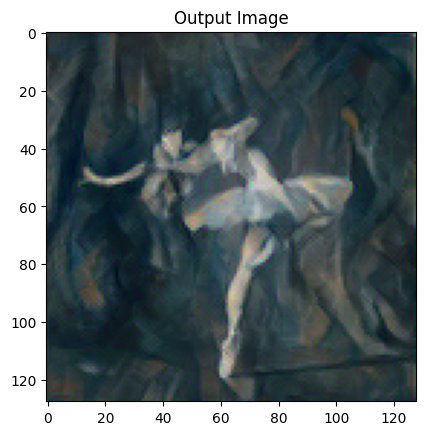

In [23]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# turn off the interactive mode to display the final output image after the style transfer process is complete
plt.ioff()
plt.show()